[View in Colaboratory](https://colab.research.google.com/github/ammar977/Image-Segmentation/blob/master/custom_model.ipynb)

In [0]:
pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


In [0]:
# 3. Load a file by ID and print its contents.
labels_id = '14ZmV19EUy7NDaLUgxE6FFCtMQ3YzBCNb'
downloaded = drive.CreateFile({'id': labels_id})

In [0]:
# 3. Load a file by ID 
images_id = '1fPniYzDESnB0HpEi0CuCkgqZiiVOWH7h'
downloaded = drive.CreateFile({'id': images_id})

In [0]:
# 3. Load a file by ID 
gt_id = '1CLwniuwqwrp6j20Rv4D9-bu0Uj2S8P3D'
downloaded = drive.CreateFile({'id': gt_id})

In [0]:
# 3. Load a file by ID 
colors_id = '1WrE2ZheAioXsG9qehKQfuN5weL5imJpa'
downloaded = drive.CreateFile({'id': colors_id})

In [0]:
# 3. Load a file by ID 
weights_id = '18Ki2zXxNEOExIo87Z38ledkxarH0kihR'
downloaded = drive.CreateFile({'id': weights_id})

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential, Model
from keras.engine.topology import Input
from keras.layers.core import Dense, Dropout, Activation,Reshape
from keras.layers import Conv1D, Conv2D, Flatten, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import Adam
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.layers.core import Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % colors_id}).GetList()

for f in file_list: 
    if f['title'] == 'label_colors.csv' :
      f.GetContentFile(f['title'])

In [0]:
os.mkdir('images')
os.chdir('images')
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % images_id}).GetList()

for f in file_list: 
    if f['title'] == '3a44ae15-58ade407(1).png' :
      continue
      
    f.GetContentFile(f['title'])


In [0]:
os.chdir('../')
os.mkdir('labels_categorical')
os.chdir('labels_categorical')

file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % labels_id}).GetList()

for f in file_list: 
    if f['title'] == '3a44ae15-58ade407(1)' :
      continue
      
    f.GetContentFile(f['title'])

In [14]:
os.chdir('../')
os.listdir()

['datalab',
 '.local',
 'label_colors.csv',
 '.cache',
 '.config',
 '.forever',
 'labels_categorical',
 '.ipython',
 'images',
 '.nv',
 '.keras',
 '.rnd']

In [0]:
dataset = []
folder = "./images/"
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
for file in files:
    dataset.append(file)

In [16]:
dataset_labels = []
folder = "./labels_categorical/"
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
for file in files:
    dataset_labels.append(file)

print (len(dataset_labels))

1000


In [0]:
dataset.sort()
dataset_labels.sort()

In [0]:
classes = pd.read_csv('./label_colors.csv',sep='\t',header=None)
classes['class'] = classes.index.values.astype(int)
classes.columns = ['rgb','name','class']

In [0]:
x_train,x_test,y_train,y_test = train_test_split(dataset,dataset_labels,test_size = 0.2)

In [0]:
batch = 10
epochs = 10;
num_classes = 41;
input_Shape = (150,150)
num_train_samples = 800
num_test_samples = 200
model_name = 'custom_resnet'

In [0]:
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
X_train = np.zeros((num_train_samples,input_Shape[0],input_Shape[1], 3 ))
for index,item in enumerate(x_train): 
    path = "./images/" + item
    img = plt.imread(path)
    new_img = cv2.resize(img,(int(input_Shape[0]),int(input_Shape[1])))
    array = np.array(new_img)
    X_train[index] = array.reshape((input_Shape[0],input_Shape[1],3)) 
    
    
X_test = np.zeros((num_test_samples,input_Shape[0],input_Shape[1], 3 ))
for index,item in enumerate(x_test):
    path = "./images/" + item
    img = plt.imread(path)
    new_img = cv2.resize(img,(int(input_Shape[0]),int(input_Shape[1])))
    array = np.array(new_img)
    X_test[index] = array.reshape((input_Shape[0],input_Shape[1],3))

In [0]:
Y_train = np.zeros((num_train_samples,input_Shape[0],input_Shape[1], num_classes ))
for index,item in enumerate(y_train): 
    path = "./labels_categorical/" + item
    Y_train[index] = np.load(path)
    
Y_test = np.zeros((num_test_samples,input_Shape[0],input_Shape[1], num_classes ))
for index,item in enumerate(y_test): 
    path = "./labels_categorical/" + item
    Y_test[index] = np.load(path)

In [0]:
def map_img(segmap) :
    t = np.zeros((input_Shape[0],input_Shape[1],3),dtype = int)
    for i in range(input_Shape[0]) :
        for j in range(input_Shape[1]):
            a = segmap[i,j,:].argmax()
            color = classes['rgb'][a].split(' ')
            t[i,j,0] = int(color[0]) 
            t[i,j,1] = int(color[1])
            t[i,j,2] = int(color[2])

    return t

In [0]:
input_img = Input(shape=(input_Shape[0],input_Shape[1],3))


Input_layer = Conv2D(64,(3,3),padding = 'same', name = 'conv1',strides = 1)(input_img)
layer_1 = Conv2D(64,(3,3),padding = 'same', name = 'conv2',strides = 1)(Input_layer)
layer_1 = BatchNormalization(name = 'BN_1')(layer_1)
layer_1 = Activation('relu')(layer_1)

shortconconv_1 = Conv2D(64,(1,1),padding = 'same', name = 'shortconconv_1',strides = 1)(Input_layer)

added_1 = keras.layers.Add()([shortconconv_1 , layer_1]) 
shortconconv_2 = Conv2D(128,(1,1),padding = 'same', name = 'shortconconv_2',strides = 1)(added_1)
shortconconv_2 = MaxPooling2D((2, 2), padding='same', name = 'pool_1', strides = 2)(shortconconv_2)


# layer_2 = Conv2D(128,(3,3),padding = 'same', name = 'maxconv_1',strides = 2)(layer_1)
layer_2 = MaxPooling2D((2, 2), padding='same', name = 'maxpool_1', strides = 2)(layer_1)
layer_2 = BatchNormalization(name = 'BN_2')(layer_2)
layer_2 = Activation('relu')(layer_2)
layer_2 = Conv2D(128,(3,3),padding = 'same', name = 'conv_3',strides = 1)(layer_2)

added_2 = keras.layers.Add()([shortconconv_2, layer_2]) 

shortconconv_3 = Conv2D(256,(1,1),padding = 'same', name = 'shortconconv_3',strides = 1)(added_2)
shortconconv_3 = MaxPooling2D((2, 2), padding='same', name = 'pool_2', strides = 2)(shortconconv_3)

layer_3 = BatchNormalization(name = 'BN_3')(added_2)
layer_3 = Activation('relu')(layer_3)
# layer_3 = Conv2D(256,(3,3),padding = 'same', name = 'maxconv_2',strides = 2)(layer_3)
layer_3 = MaxPooling2D((2, 2), padding='same', name = 'maxpool_2', strides = 2)(layer_3)
layer_3 = BatchNormalization(name = 'BN_4')(layer_3)
layer_3 = Activation('relu')(layer_3)
layer_3 = Conv2D(256,(3,3),padding = 'same', name = 'conv_4',strides = 1)(layer_3)

added_3 = keras.layers.Add()([shortconconv_3, layer_3]) 
shortconconv_4 = Conv2D(512,(1,1),padding = 'same', name = 'shortconconv_4',strides = 1)(added_3)
shortconconv_4 = MaxPooling2D((2, 2), padding='same', name = 'pool_3', strides = 2)(shortconconv_4)

bridge = BatchNormalization(name = 'BN_5')(added_3)
bridge = Activation('relu')(bridge)
# bridge = Conv2D(512,(3,3),padding = 'same', name = 'maxconv_3',strides = 2)(bridge)
bridge = MaxPooling2D((2, 2), padding='same', name = 'maxpool_3', strides = 2)(bridge)
bridge = BatchNormalization(name = 'BN_6')(bridge)
bridge = Activation('relu')(bridge)
bridge = Conv2D(512,(3,3),padding = 'same', name = 'conv_5',strides = 1)(bridge)


added_4 = keras.layers.Add()([shortconconv_4, bridge]) 

# DECODER

upsample_1 = UpSampling2D((2, 2),name = 'upsample_1')(added_4)

concat_1 = keras.layers.concatenate([added_3,upsample_1],axis = -1)
shortconconv_5 = Conv2D(256,(1,1),padding = 'same', name = 'shortconconv_5',strides = 1)(concat_1)

decoder_layer_1 = BatchNormalization(name = 'BN_7')(concat_1)
decoder_layer_1  = Activation('relu')(decoder_layer_1)
decoder_layer_1 = Conv2D(256,(3,3),padding = 'same', name = 'deconv_1',strides = 1)(decoder_layer_1)
decoder_layer_1 = BatchNormalization(name = 'BN_8')(decoder_layer_1)
decoder_layer_1  = Activation('relu')(decoder_layer_1)
decoder_layer_1 = Conv2D(256,(3,3),padding = 'same', name = 'deconv_2',strides = 1)(decoder_layer_1)

added_5 = keras.layers.Add()([shortconconv_5, decoder_layer_1]) 
upsample_2 = UpSampling2D((2, 2),name = 'upsample_2')(added_5)

added_2_pad = Lambda(lambda x: tf.pad(x,paddings=tf.constant([[0, 0,], [1, 0,],[1,0,],[0,0]]) ,mode="REFLECT",name='pad_1'))(added_2)

concat_2 = keras.layers.concatenate([added_2_pad,upsample_2],axis = -1)
shortconconv_6 = Conv2D(128,(1,1),padding = 'same', name = 'shortconconv_6',strides = 1)(concat_2)

decoder_layer_2 = BatchNormalization(name = 'BN_9')(concat_2)
decoder_layer_2  = Activation('relu')(decoder_layer_2)
decoder_layer_2 = Conv2D(128,(3,3),padding = 'same', name = 'deconv_3',strides = 1)(decoder_layer_2)
decoder_layer_2 = BatchNormalization(name = 'BN_10')(decoder_layer_2)
decoder_layer_2  = Activation('relu')(decoder_layer_2)
decoder_layer_2 = Conv2D(128,(3,3),padding = 'same', name = 'deconv_4',strides = 1)(decoder_layer_2)


added_6 = keras.layers.Add()([shortconconv_6, decoder_layer_2]) 
upsample_3 = UpSampling2D((2, 2),name = 'upsample_3')(added_6)

added_1_pad = Lambda(lambda x: tf.pad(x,paddings=tf.constant([[0, 0,], [1, 1,],[1,1,],[0,0]]) ,mode="REFLECT",name='pad_1'))(added_1)

concat_3 = keras.layers.concatenate([added_1_pad,upsample_3],axis = -1)
shortconconv_6 = Conv2D(64,(3,3),padding = 'valid', name = 'shortconconv_7',strides = 1)(concat_3)

decoder_layer_3 = BatchNormalization(name = 'BN_11')(concat_3)
decoder_layer_3  = Activation('relu')(decoder_layer_3)
decoder_layer_3 = Conv2D(64,(3,3),padding = 'same', name = 'deconv_5',strides = 1)(decoder_layer_3)
decoder_layer_3 = BatchNormalization(name = 'BN_12')(decoder_layer_3)
decoder_layer_3  = Activation('relu')(decoder_layer_3)
decoder_layer_3 = Conv2D(64,(3,3),padding = 'valid', name = 'deconv_6',strides = 1)(decoder_layer_3)

added_7 = keras.layers.Add()([shortconconv_6, decoder_layer_3]) 

output = Conv2D(num_classes,(1,1),padding = 'valid', name = 'deconv_7',strides = 1)(added_7)
output = Activation('softmax')(output)

autoencoder = Model(input_img, output)

In [34]:
autoencoder.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 150, 150, 64) 36928       conv1[0][0]                      
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 150, 150, 64) 256         conv2[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Code for storing history of model 
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5',monitor='val_acc',verbose = 2,save_best_only = True,save_weights_only = True, mode = 'auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 4, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./'+model_name, histogram_freq=0, batch_size=batch, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 4, min_lr=0.001)
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append= True)
callbacks = [checkpoint,tensorboard, earlystop, csvlogger, rp]

In [31]:
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % weights_id}).GetList()
print (len(file_list))
for f in file_list: 
    if f['title'] == 'labels_categorical' :
      continue
      
    f.GetContentFile(f['title'])
    starting_weights = f['title']

2


In [0]:
# autoencoder.load_weights(model_name+'/'+model_name+'.h5')
# autoencoder.load_weights(model_name + 'my_weights.h5')
autoencoder.load_weights(starting_weights)

In [0]:
del [x_train,y_train,file_list,dataset,dataset_labels]

In [54]:
# Fine-tune the model with your dataset for segmentation
auto_encoder_train = autoencoder.fit(X_train,Y_train, batch_size = batch , epochs=epochs,callbacks = callbacks,validation_data = (X_test,Y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 67s 83ms/step - loss: 0.4348 - acc: 0.8900 - val_loss: 1.6348 - val_acc: 0.7444

Epoch 00001: val_acc did not improve from 0.77272
Epoch 2/10
800/800 [==============================] - 66s 83ms/step - loss: 0.4283 - acc: 0.8928 - val_loss: 1.7997 - val_acc: 0.7320

Epoch 00002: val_acc did not improve from 0.77272
Epoch 3/10
800/800 [==============================] - 66s 83ms/step - loss: 0.4368 - acc: 0.8881 - val_loss: 1.7182 - val_acc: 0.7522

Epoch 00003: val_acc did not improve from 0.77272
Epoch 4/10
300/800 [==========>...................] - ETA: 37s - loss: 0.4247 - acc: 0.8884

800/800 [==============================] - 66s 83ms/step - loss: 0.4173 - acc: 0.8847 - val_loss: 1.7385 - val_acc: 0.7296

Epoch 00004: val_acc did not improve from 0.77272
Epoch 5/10
800/800 [==============================] - 66s 83ms/step - loss: 0.4186 - acc: 0.8824 - val_loss: 1.6681 - val_acc: 0.7454

Epoch 00005: val_acc did not improve from 0.77272


In [0]:
autoencoder.save_weights(model_name + 'my_weights.h5')

In [0]:
# from google.colab import files
# files.download(model_name+'/'+model_name+'.h5')
files.download(model_name + 'my_weights.h5')

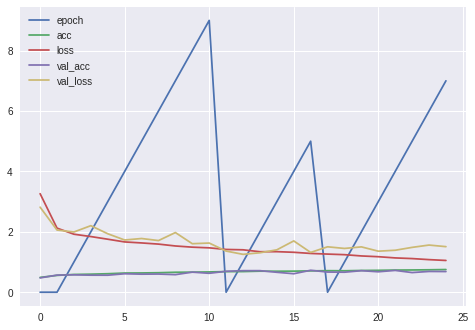

In [42]:
pd.read_csv(model_name+'/logs.csv').plot()
plt.show()

In [55]:
scores = autoencoder.evaluate(X_test,Y_test)
print (scores)

200/200 [==============================] - 5s 26ms/step
[1.678383560180664, 0.730177776813507]
